In [36]:
using Pkg
Pkg.activate("BosonStars")
using Skylight
using StatsBase
using CairoMakie
using LinearAlgebra
using Printf
using Colors
using DataFrames
using GLM
include("corona.jl")
include("ranges.jl")
include("juliacolors.jl")

  Activating project at `~/BosonStars/BosonStars`


   Resolving package versions...


    Updating `~/BosonStars/BosonStars/Project.toml`
  [a93c6f00] + DataFrames v1.6.1
    Updating `~/BosonStars/BosonStars/Manifest.toml`
 

 [a8cc5b0e] + Crayons v4.1.1
  [a93c6f00] + DataFrames v1.6.1
  [842dd82b] + InlineStrings v1.4.0
  [41ab1584] + InvertedIndices v1.3.0
  [2dfb63ee] + PooledArrays v1.4.2
  [08abe8d2] + PrettyTables v2.2.7
  [91c51154] + SentinelArrays v1.4.0
  [892a3eda] + StringManipulation v0.3.0


Precompiling 

project...


  ✓ InlineStrings


  ✓ DataFrames


  ✓ BosonStars
  3 dependencies successfully precompiled in 76 seconds. 315 already precompiled.


   Resolving package versions...


    Updating `~/BosonStars/BosonStars/Project.toml`
  [38e38edf] + GLM v1.8.3
    Updating `~/BosonStars/BosonStars/Manifest.toml`
 

 [38e38edf] + GLM v1.8.3
  [1277b4bf] + ShiftedArrays v2.0.0
  [3eaba693] + StatsModels v0.7.2


Precompiling 

project...


  ✓ StatsModels


  ✓ GLM


  ✓ BosonStars
  3 dependencies successfully precompiled in 15 seconds. 318 already precompiled.


Boson star

In [31]:
modelname = "LBS"
modelid = 3
filenames = get_filenames(modelname)
obs_configurations = load_configurations_from_hdf5("io/$(filenames[modelid,1]).h5")
spacetime = obs_configurations.spacetime
disk = obs_configurations.radiative_model

AccretionDiskWithTabulatedTemperature{ProgradeRotation, DataInterpolations.LinearInterpolation{Vector{Float64}, Vector{Float64}, true, Float64}}
  inner_radius: Float64 0.1
  outer_radius: Float64 79.6
  rotation_sense: ProgradeRotation ProgradeRotation()
  filename: String "tables/TempLBS3.dat"
  temperature_interpolator: DataInterpolations.LinearInterpolation{Vector{Float64}, Vector{Float64}, true, Float64}


In [33]:
corona = LamppostCorona(height=10.0, theta_offset=1e-5, spectral_index = 2.0)
configurations = VacuumETOConfigurations(spacetime=spacetime,
                                   radiative_model = corona,
                                   number_of_points=1,
                                   number_of_packets_per_point = 1000000, 
                                   max_radius = 110.0,
                                   unit_mass_in_solar_masses=1.0)
initial_data = initialize_serial(configurations)
cbp = callback_parameters(spacetime, disk, configurations)
cb = callback(spacetime, disk)
sim = integrate(initial_data, configurations, cb, cbp; method=VCABM(), reltol=1e-5, abstol=1e-5)
output_data = sim.output_data
at_source = map(position -> is_final_position_at_source(position, spacetime, disk) && position[3] ≈ π/2, eachcol(output_data))
radii = output_data[2,at_source]
q = energies_quotients(output_data[:,at_source], spacetime, disk)
bins = radial_bins(disk, nbins=100)
# bins = r_in*exp10.(range(0.0, stop=log10(r_out/r_in), length=100))
A = ring_areas(bins, spacetime)
γ = lorentz_factors(bins, spacetime, disk)
h = fit(Histogram, radii, bins)
h = normalize(h, mode=:probability)
𝓝 = h.weights

qavg = average_inside_radial_bins(q, radii, bins)

Γ = corona.spectral_index
n = 𝓝./(A.*γ)
I = qavg.^Γ.*n

bins_midpoints = 0.5*(bins[1:end-1] + bins[2:end])


┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00014478834557952251, and step error estimate = 0.33908749066499366. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00010017545589684631, and step error estimate = 1.0713617209823645. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00010052048041926799, and step error estimate = 1.1410995438577065. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:5

Equations integration stats:
Wall clock time: 64.803027929 seconds
Memory allocated: 120.091 GiB


MethodError: MethodError: no method matching ndigits(::Vector{Float64}; base::Int64, pad::Int64)

Closest candidates are:
  ndigits(!Matched::Integer; base, pad)
   @ Base intfuncs.jl:671


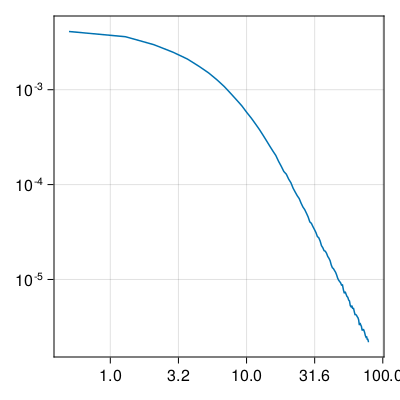

In [46]:
hstr = string(@sprintf("%02d", corona.height))
istr = string(@sprintf("%02d", corona.spectral_index))
filename = "io/corona/bosonstar/$(modelname)$(modelid)_h$(hstr)_idx$(istr).txt"
open(filename, "w") do io
    writedlm(io, [bins_midpoints I])
end

fig = Figure(resolution=(400,400))
ax = Axis(fig[1,1])
lines!(ax, bins_midpoints, I)
ax.xscale = log10
ax.yscale = log10
# xlims!(1.0,200)
# ylims!(1e-6, 1e0)
ax.xtickformat = "{:.1f}"
fig

In [43]:
bins_midpoints[40]

31.5025

In [45]:
imin = 35
df = DataFrame(logr = log10.(bins_midpoints[imin:end]), logI = log10.(I[imin:end]))
ols = lm(@formula(logI ~ logr), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

logI ~ 1 + logr

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.0466288   0.0186558    -2.50    0.0150  -0.0838981  -0.0093596
logr         -2.95576     0.0108885  -271.46    <1e-98  -2.97752    -2.93401
──────────────────────────────────────────────────────────────────────────────

Kerr black hole

In [21]:
spacetime = KerrSpacetimeBoyerLindquistCoordinates(M=1.0,a=0.998)
corona = LamppostCorona(height=10.0, theta_offset=1e-5, spectral_index = 2.0)
configurations = VacuumETOConfigurations(spacetime=spacetime,
                                   radiative_model = corona,
                                   number_of_points=1,
                                   number_of_packets_per_point = 1000000, 
                                   max_radius = 110.0,
                                   unit_mass_in_solar_masses=1.0)
initial_data = initialize_serial(configurations)
disk = NovikovThorneDisk(inner_radius = isco_radius(spacetime, ProgradeRotation()), outer_radius = 100.0)
cbp = callback_parameters(spacetime, disk, configurations; rhorizon_bound=2e-3)
cb = callback(spacetime, disk)
sim = integrate(initial_data, configurations, cb, cbp; method=VCABM(), reltol=1e-5, abstol=1e-5)
output_data = sim.output_data
at_source = map(position -> is_final_position_at_source(position, spacetime, disk) && position[3] ≈ π/2, eachcol(output_data))
radii = output_data[2,at_source]
q = energies_quotients(output_data[:,at_source], spacetime, disk)
bins = radial_bins(disk, nbins=100)
# bins = r_in*exp10.(range(0.0, stop=log10(r_out/r_in), length=100))
A = ring_areas(bins, spacetime)
γ = lorentz_factors(bins, spacetime, disk)
h = fit(Histogram, radii, bins)
h = normalize(h, mode=:probability)
𝓝 = h.weights

qavg = average_inside_radial_bins(q, radii, bins)

Γ = corona.spectral_index
n = 𝓝./(A.*γ)
I = qavg.^Γ.*n

bins_midpoints = 0.5*(bins[1:end-1] + bins[2:end])

astr = string(@sprintf("%02d", spacetime.a))
hstr = string(@sprintf("%02d", corona.height))
istr = string(@sprintf("%02d", corona.spectral_index))
filename = "io/corona/kerr/a$(astr)_h$(hstr)_idx$(istr).txt"
open(filename, "w") do io
    writedlm(io, [bins_midpoints I])
end

fig = Figure(resolution=(400,400))
ax = Axis(fig[1,1])
lines!(ax, bins_midpoints, I)
ax.xscale = log10
ax.yscale = log10
xlims!(1.0,200)
ylims!(1e-6, 1e0)
ax.xtickformat = "{:.1f}"
fig

┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.0001007112978891871, and step error estimate = 1.7114279151537375. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00010268615217823033, and step error estimate = 1.8184494778480798. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00010441856516686471, and step error estimate = 0.922296242919113. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599


Equations integration stats:
Wall clock time: 107.877295453 seconds
Memory allocated: 322.862 GiB


LoadError: LoadError: UndefVarError: `@sprintf` not defined
in expression starting at /home/jpelle/BosonStars/corona.ipynb:34

In [15]:
df = DataFrame(logr = log10.(bins_midpoints[16:end]), logI = log10.(I[16:end]))
ols = lm(@formula(logI ~ logr), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

logI ~ 1 + logr

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   0.020696  0.0154046      1.34    0.1883  -0.0106449   0.0520368
logr         -2.99434   0.00856143  -349.75    <1e-59  -3.01175    -2.97692
─────────────────────────────────────────────────────────────────────────────